In [1]:
import glob
import os
import numpy as np
import pandas as pd
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import fdrcorrection as FDR_BH
from collections import Counter
from tqdm.auto import tqdm

In [2]:
redc_chP = "/home/daniil/Desktop/bioinformatics_group/K562.pvalue.tab"
grid_chP = "/home/daniil/Desktop/bioinformatics_group/associativity/featureCounts/ES_grid_rnaseqMENCODE.chP.tab"

# K562 cell line

## fRIP K562

In [9]:
# prepare data for tables
cls = ["gene", "count"]
cldct = {i : cl for i, cl in enumerate(cls)}

chp_table = pd.read_csv(redc_chP, sep='\t').loc[:,["gene_name_un", "zscore"]]

# load input counts
with open("frip_k562_cnts/INPUT.EXPERIMENT.counts.txt", 'r') as fin:
    input_dct = {}
    for line in fin:
        k, v = line.split('\t')[0], int(line.split('\t')[1].strip())
        input_dct[k] = v
    input_cnts = pd.DataFrame.from_dict(input_dct.items()).rename(columns = cldct)
    del input_dct

# read protein list
protein_list = pd.Series(glob.glob("frip_k562_cnts/*")).apply(lambda x: x.split('/')[1].split('.')[0])
protein_list = protein_list[~protein_list.str.startswith("INPUT")]
res_dt_fRIP = {p : 0 for p in protein_list}
dfl = []

for PROT in tqdm(protein_list):
    
    # load protein counts
    fname = f"frip_k562_cnts/{PROT}.EXPERIMENT.counts.txt"
    with open(fname, 'r') as fin:
        exp_d = {}
        for line in fin:
            k, v = line.split('\t')[0], int(line.split('\t')[1].strip())
            exp_d[k] = v
        exp_cnts = pd.DataFrame.from_dict(exp_d.items()).rename(columns = cldct)
        del exp_d

    df = (exp_cnts.merge(input_cnts, how="outer", on="gene", suffixes=("_exp", "_inp"))
          .fillna(value=0)
          .set_index("gene")
         ) + 1
    df["FC"] = df.count_exp/df.count_inp
    df = df.reset_index().merge(chp_table, left_on="gene", right_on="gene_name_un")

    df["abFCthr"] = df.FC.apply(lambda x: 1 if x > 1 else 0)
    df["abZSthr"] = df.zscore.apply(lambda x: 1 if x > 1.5 else 0)
    df["protein"] = PROT
    
    dfl.append(df.iloc[:, [0,1,2,3,8]])
    res_dt_fRIP[PROT] = fisher_exact(pd.crosstab(df.abFCthr, df.abZSthr) + 1)

  0%|          | 0/17 [00:00<?, ?it/s]

In [14]:
res_dt_fRIP

{'CHD1': SignificanceResult(statistic=0.782056229611106, pvalue=0.5140118799972828),
 'PCAF': SignificanceResult(statistic=0.11498415421839277, pvalue=1.1195428577518477e-14),
 'CTCF': SignificanceResult(statistic=0.46891271261114525, pvalue=0.0697408489269874),
 'DNMT1': SignificanceResult(statistic=0.2356082577938548, pvalue=1.1005372741346647e-26),
 'PHF8': SignificanceResult(statistic=0.4496188372300895, pvalue=0.21143003454977688),
 'SUZ12': SignificanceResult(statistic=0.5771083836072395, pvalue=0.007169982703091488),
 'CBP': SignificanceResult(statistic=0.6019964514387102, pvalue=0.0030429039338405067),
 'LSD1': SignificanceResult(statistic=1.0522867389531259, pvalue=0.7822240792223181),
 'CBX3': SignificanceResult(statistic=0.6599396327955228, pvalue=0.35591293896993426),
 'HNRNPH': SignificanceResult(statistic=1.1360182370820668, pvalue=0.5050942366826813),
 'CHD7': SignificanceResult(statistic=0.5649094758153604, pvalue=0.19101775236795815),
 'NUP98': SignificanceResult(stati

17

## eCLIP K562

In [13]:
# prepare data for tables
cls = ["gene", "count"]
cldct = {i : cl for i, cl in enumerate(cls)}

chp_table = pd.read_csv(redc_chP, sep='\t').loc[:,["gene_name_un", "zscore"]]

# read protein list
protein_list = (pd.Series(glob.glob("eclip_k562_cnts/*")).apply(lambda x: x.split('/')[1].split('.')[0])
                .drop_duplicates())
protein_list = protein_list[~protein_list.str.startswith("INPUT")]
res_dt_eCLIP = {p : 0 for p in protein_list}


for PROT in tqdm(protein_list):
    
    # load input counts
    fname = f"eclip_k562_cnts/{PROT}.INPUT.txt.counts.txt"
    with open(fname, 'r') as fin:
        input_dct = eval(fin.readline())
        input_cnts = pd.DataFrame.from_dict(input_dct.items()).rename(columns = cldct)
        del input_dct
    
    # load protein counts
    fname = f"eclip_k562_cnts/{PROT}.EXPERIMENT.txt.counts.txt"
    with open(fname, 'r') as fin:
        exp_d = eval(fin.readline())
        exp_cnts = pd.DataFrame.from_dict(exp_d.items()).rename(columns = cldct)
        del exp_d

    df = (exp_cnts.merge(input_cnts, how="outer", on="gene", suffixes=("_exp", "_inp"))
          .fillna(value=0)
          .set_index("gene")
         ) + 1
    df["FC"] = df.count_exp/df.count_inp
    df = df.reset_index().merge(chp_table, left_on="gene", right_on="gene_name_un")

    df["abFCthr"] = df.FC.apply(lambda x: 1 if x > 1 else 0)
    df["abZSthr"] = df.zscore.apply(lambda x: 1 if x > 1.5 else 0)
    df["protein"] = PROT
    
    dfl.append(df.iloc[:, [0,1,2,3,8]])
    
    
    res_dt_eCLIP[PROT] = fisher_exact(pd.crosstab(df.abFCthr, df.abZSthr) + 1)


  0%|          | 0/30 [00:00<?, ?it/s]

In [16]:
pd.concat(dfl).to_csv("K562_counts_data.tsv", sep='\t', index=False)

In [21]:
res_dt_fRIP.update(res_dt_eCLIP)

In [22]:
res_K562 = { k : v[1] for k,v in res_dt_fRIP.items()}

In [23]:
res_K562

{'CHD1': 0.5140118799972828,
 'PCAF': 1.1195428577518477e-14,
 'CTCF': 0.0697408489269874,
 'DNMT1': 1.1005372741346647e-26,
 'PHF8': 0.21143003454977688,
 'SUZ12': 0.007169982703091488,
 'CBP': 0.0030429039338405067,
 'LSD1': 0.7822240792223181,
 'CBX3': 0.35591293896993426,
 'HNRNPH': 0.5050942366826813,
 'CHD7': 0.19101775236795815,
 'NUP98': 0.016443183447168688,
 'EZH2': 1.0890592682837522e-06,
 'CHD4': 0.0018746454948301104,
 'WDR5': 0.12957393155520933,
 'RBBP5': 0.3544726921653937,
 'HDAC1': 0.1471527965907802,
 'HNRNPUL1': 0.7135598696692396,
 'HNRNPC': 1.4033599828307618e-08,
 'SRSF7': 6.531960253565216e-14,
 'HLTF': 0.09165247169263924,
 'SAFB': 2.4342793348588586e-22,
 'TARDBP': 0.010268342890980019,
 'YBX3': 2.764623672689009e-19,
 'HNRNPL': 8.500742872140652e-08,
 'PCBP1': 1.8281296114933563e-10,
 'EWSR1': 9.942668002864015e-31,
 'LARP7': 0.15770388941410607,
 'MORC2': 0.06862382185009507,
 'NONO': 8.029619724138668e-18,
 'ILF3': 0.9521046327933513,
 'FUS': 2.155900382069

In [18]:
f = pd.Series(res_K562)
- np.log10(f[f < 0.05]).sort_values().round(3)

RBM15      35.640
RBM22      30.846
EWSR1      30.002
SAFB       21.614
YBX3       18.558
NONO       17.095
DNMT1      16.728
SRSF7      13.185
SRSF1      10.722
FUS        10.666
PCBP1       9.738
SRSF9       8.344
HNRNPC      7.853
HNRNPL      7.071
HNRNPH      6.369
ZC3H11A     5.398
RBFOX2      5.341
U2AF2       5.073
PTBP1       2.822
PABP        2.420
ZC3H8       2.408
TARDBP      1.988
SAFB2       1.972
CHD4        1.881
HNRNPU      1.843
WDR5        1.687
STAG2       1.545
dtype: float64

In [32]:
(pd.DataFrame.from_dict(
    {k : {"PVAL": v, "QVAL":t} 
     for k,v, t in zip(res_K562.keys(), res_K562.values(), FDR_BH(list(res_K562.values()))[1])}).transpose()
).to_csv("fishertest_new.txt", sep='\t')

# Коррелограммы и РНК-вектора

1. Собрать названия генов РНК из всех триад
2. Построить хитмап только на хроматин-ассоциированных на K562
3. Построить хитмап на всех белках для обоих клетлиний
4. Коррелограмма на хрроматин-ассоциированных на K562
5. Коррелограмма на всех белках для обоих клетлиний.

In [10]:
! cut -f 8,9 /home/daniil/Desktop/bioinformatics_group/TRIADS_2023/TRIADS/*K562*HMP* | sort -u > rnas_K562.tsv
! cut -f 8,9 /home/daniil/Desktop/bioinformatics_group/TRIADS_2023/TRIADS/*mESC*HMP* | sort -u > rnas_mESC.tsv

In [11]:
k562_rna = pd.read_csv("rnas_K562.tsv", sep='\t', header=None).rename(columns={0:"name", 1:"type"})
mesc_rna = pd.read_csv("rnas_mESC.tsv", sep='\t', header=None).rename(columns={0:"name", 1:"type"})
redc_rna = pd.read_table(redc_chP)
grid_rna = pd.read_table(grid_chP)

In [12]:
triad_rna_K562 = k562_rna.merge(redc_rna, left_on="name", right_on="gene_name_un").loc[:, ["name", "type", "zscore"]]
triad_rna_mESC = mesc_rna.merge(grid_rna, left_on="name", right_on="gene_name_un").loc[:, ["name", "type", "zscore"]]

In [6]:
# prepare data for tables
cls = ["gene", "count"]
cldct = {i : cl for i, cl in enumerate(cls)}

chp_table = pd.read_csv(redc_chP, sep='\t').loc[:,["gene_name_un", "zscore"]]

# load input counts
with open("fRIP_K562/INPUT.EXPERIMENT.counts.txt", 'r') as fin:
    input_dct = eval(fin.readline())
    input_cnts = pd.DataFrame.from_dict(input_dct.items()).rename(columns = cldct)
    del input_dct

# read protein list
protein_list = pd.Series(glob.glob("fRIP_K562/*")).apply(lambda x: x.split('/')[1].split('.')[0])
protein_list = protein_list[~protein_list.str.startswith("INPUT")]
res_dt_fRIP = {p : 0 for p in protein_list}

l = []
for PROT in tqdm(protein_list):
    
    # load protein counts
    fname = f"fRIP_K562/{PROT}.EXPERIMENT.counts.txt"
    with open(fname, 'r') as fin:
        exp_d = eval(fin.readline())
        exp_cnts = pd.DataFrame.from_dict(exp_d.items()).rename(columns = cldct)
        del exp_d

    df = (exp_cnts.merge(input_cnts, how="outer", on="gene", suffixes=("_exp", "_inp"))
          .fillna(value=0)
          .set_index("gene")
         ) + 1
    df["FC"] = df.count_exp/df.count_inp
    cols = ["gene", "FC"]
    df = (df.reset_index()
          .merge(chp_table, left_on="gene", right_on="gene_name_un")
          .loc[:, cols]
          .rename(columns={"FC": f"{PROT}_signal"})
         )
    l.append(df)

  0%|          | 0/24 [00:00<?, ?it/s]

In [7]:
# prepare data for tables
cls = ["gene", "count"]
cldct = {i : cl for i, cl in enumerate(cls)}

chp_table = pd.read_csv(redc_chP, sep='\t').loc[:,["gene_name_un", "zscore"]]

# read protein list
protein_list = (pd.Series(glob.glob("eCLIP_K562/*")).apply(lambda x: x.split('/')[1].split('.')[0])
                .drop_duplicates())

protein_list = protein_list[~protein_list.str.startswith("INPUT")]
res_dt_eCLIP = {p : 0 for p in protein_list}



for PROT in tqdm(protein_list):

    # load input counts
    fname = f"eCLIP_K562/{PROT}.INPUT.txt"
    with open(fname, 'r') as fin:
        input_dct = eval(fin.readline())
        input_cnts = pd.DataFrame.from_dict(input_dct.items()).rename(columns = cldct)
        del input_dct
    
    # load protein counts
    fname = f"eCLIP_K562/{PROT}.EXPERIMENT.txt"
    with open(fname, 'r') as fin:
        exp_d = eval(fin.readline())
        exp_cnts = pd.DataFrame.from_dict(exp_d.items()).rename(columns = cldct)
        del exp_d

    df = (exp_cnts.merge(input_cnts, how="outer", on="gene", suffixes=("_exp", "_inp"))
          .fillna(value=0)
          .set_index("gene")
         ) + 1
    df["FC"] = df.count_exp/df.count_inp
    cols = ["gene", "FC"]
    df = (df.reset_index()
          .merge(chp_table, left_on="gene", right_on="gene_name_un")
          .loc[:, cols]
          .rename(columns={"FC": f"{PROT}_signal"})
         )
    l.append(df)

  0%|          | 0/30 [00:00<?, ?it/s]

In [8]:
from functools import reduce

fc_tbl = reduce(lambda df1,df2: pd.merge(df1,df2,on='gene', how="outer").fillna(10e-6), l)

In [9]:
fc_tbl = fc_tbl.merge(triad_rna_K562, left_on="gene", right_on="name").iloc[:, [*range(55),56, 57]]

In [13]:
fc_tbl.to_csv("/home/daniil/Desktop/bioinformatics_group/FOLD_CHANGES_K562.tab", sep='\t', header=True, index=False)

In [11]:
fc_tbl

,gene,PABP_signal,CHD1_signal,STAG2_signal,PCBX_signal,PCAF_signal,IMP1_signal,CTCF_signal,DNMT1_signal,HUR_signal,...,FUS_signal,PTBP1_signal,U2AF2_signal,GTF2F1_signal,HNRNPC_signal,EWSR1_signal,SRSF9_signal,LARP7_signal,type,zscore
0,RN7SL2,0.044810,0.049619,0.025239,0.034983,0.055938,0.024398,0.074966,0.030308,0.007923,...,0.117652,0.008239,0.070374,0.084771,0.124583,0.018408,0.063746,0.162318,misc_RNA,-6.486906
1,SNHG5,1.760817,0.151217,0.052861,0.109870,0.178426,0.157169,0.092837,0.331166,0.048832,...,9.582734,1.550681,3.173397,1.187050,12.415771,0.537815,0.774194,0.438202,lncRNA,0.285222
2,GAS5,1.207257,0.259526,0.094964,0.162940,0.243709,0.158901,0.122567,0.381873,0.058166,...,8.084112,3.348561,2.284628,1.210855,12.770925,0.292168,0.461818,0.461674,lncRNA,1.748727
3,SNHG1,1.079658,0.300641,0.139111,0.213980,0.356588,0.981060,0.126215,0.858380,0.064120,...,3.209105,2.123102,3.409899,1.019249,1.173849,0.248287,0.509063,0.474997,lncRNA,0.708719
4,MIR924HG,0.959781,0.215636,0.113956,0.182944,0.462537,0.155102,0.229929,0.277132,0.067162,...,20.563910,1.529032,1.375776,1.624434,26.075342,0.628141,1.307692,0.510714,lncRNA,0.881103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,FTX,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,...,6.627592,0.640055,5.680103,1.472252,34.911426,0.636630,0.485366,0.129944,lncRNA,1.599703
131,DANT2,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,...,68.678363,3.254480,3.872549,5.082609,20.794643,11.139535,0.730769,1.177474,lncRNA,0.921112
132,NKAPP1,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,...,8.655327,1.707465,2.919847,2.189274,22.913345,0.773636,0.721311,0.295991,transcribed_processed_pseudogene,0.803361
133,LINC01278,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,...,9.687719,2.214600,4.319703,2.093258,27.980707,0.849655,0.750000,0.162450,lncRNA,1.015752


In [142]:
ca_prots = list(map(lambda x: x + "_signal", ['RBM15', 'RBM22', 'EWSR1', 'SAFB', 'YBX3', 'NONO',
            'DNMT1', 'SRSF7', 'SRSF1', 'FUS', 'PCBP1',
            'SRSF9', 'HNRNPC', 'HNRNPL', 'HNRNPH', 'ZC3H11A',
            'RBFOX2', 'U2AF2', 'PTBP1', 'PABP', 'WDR5', 'ZC3H8', 
            'TARDBP', 'SAFB2', 'HNRNPUL1', 'SUZ12', 'CHD4', 'STAG2']))

fc_tbl = fc_tbl.loc[fc_tbl.zscore > 1.5, ca_prots]

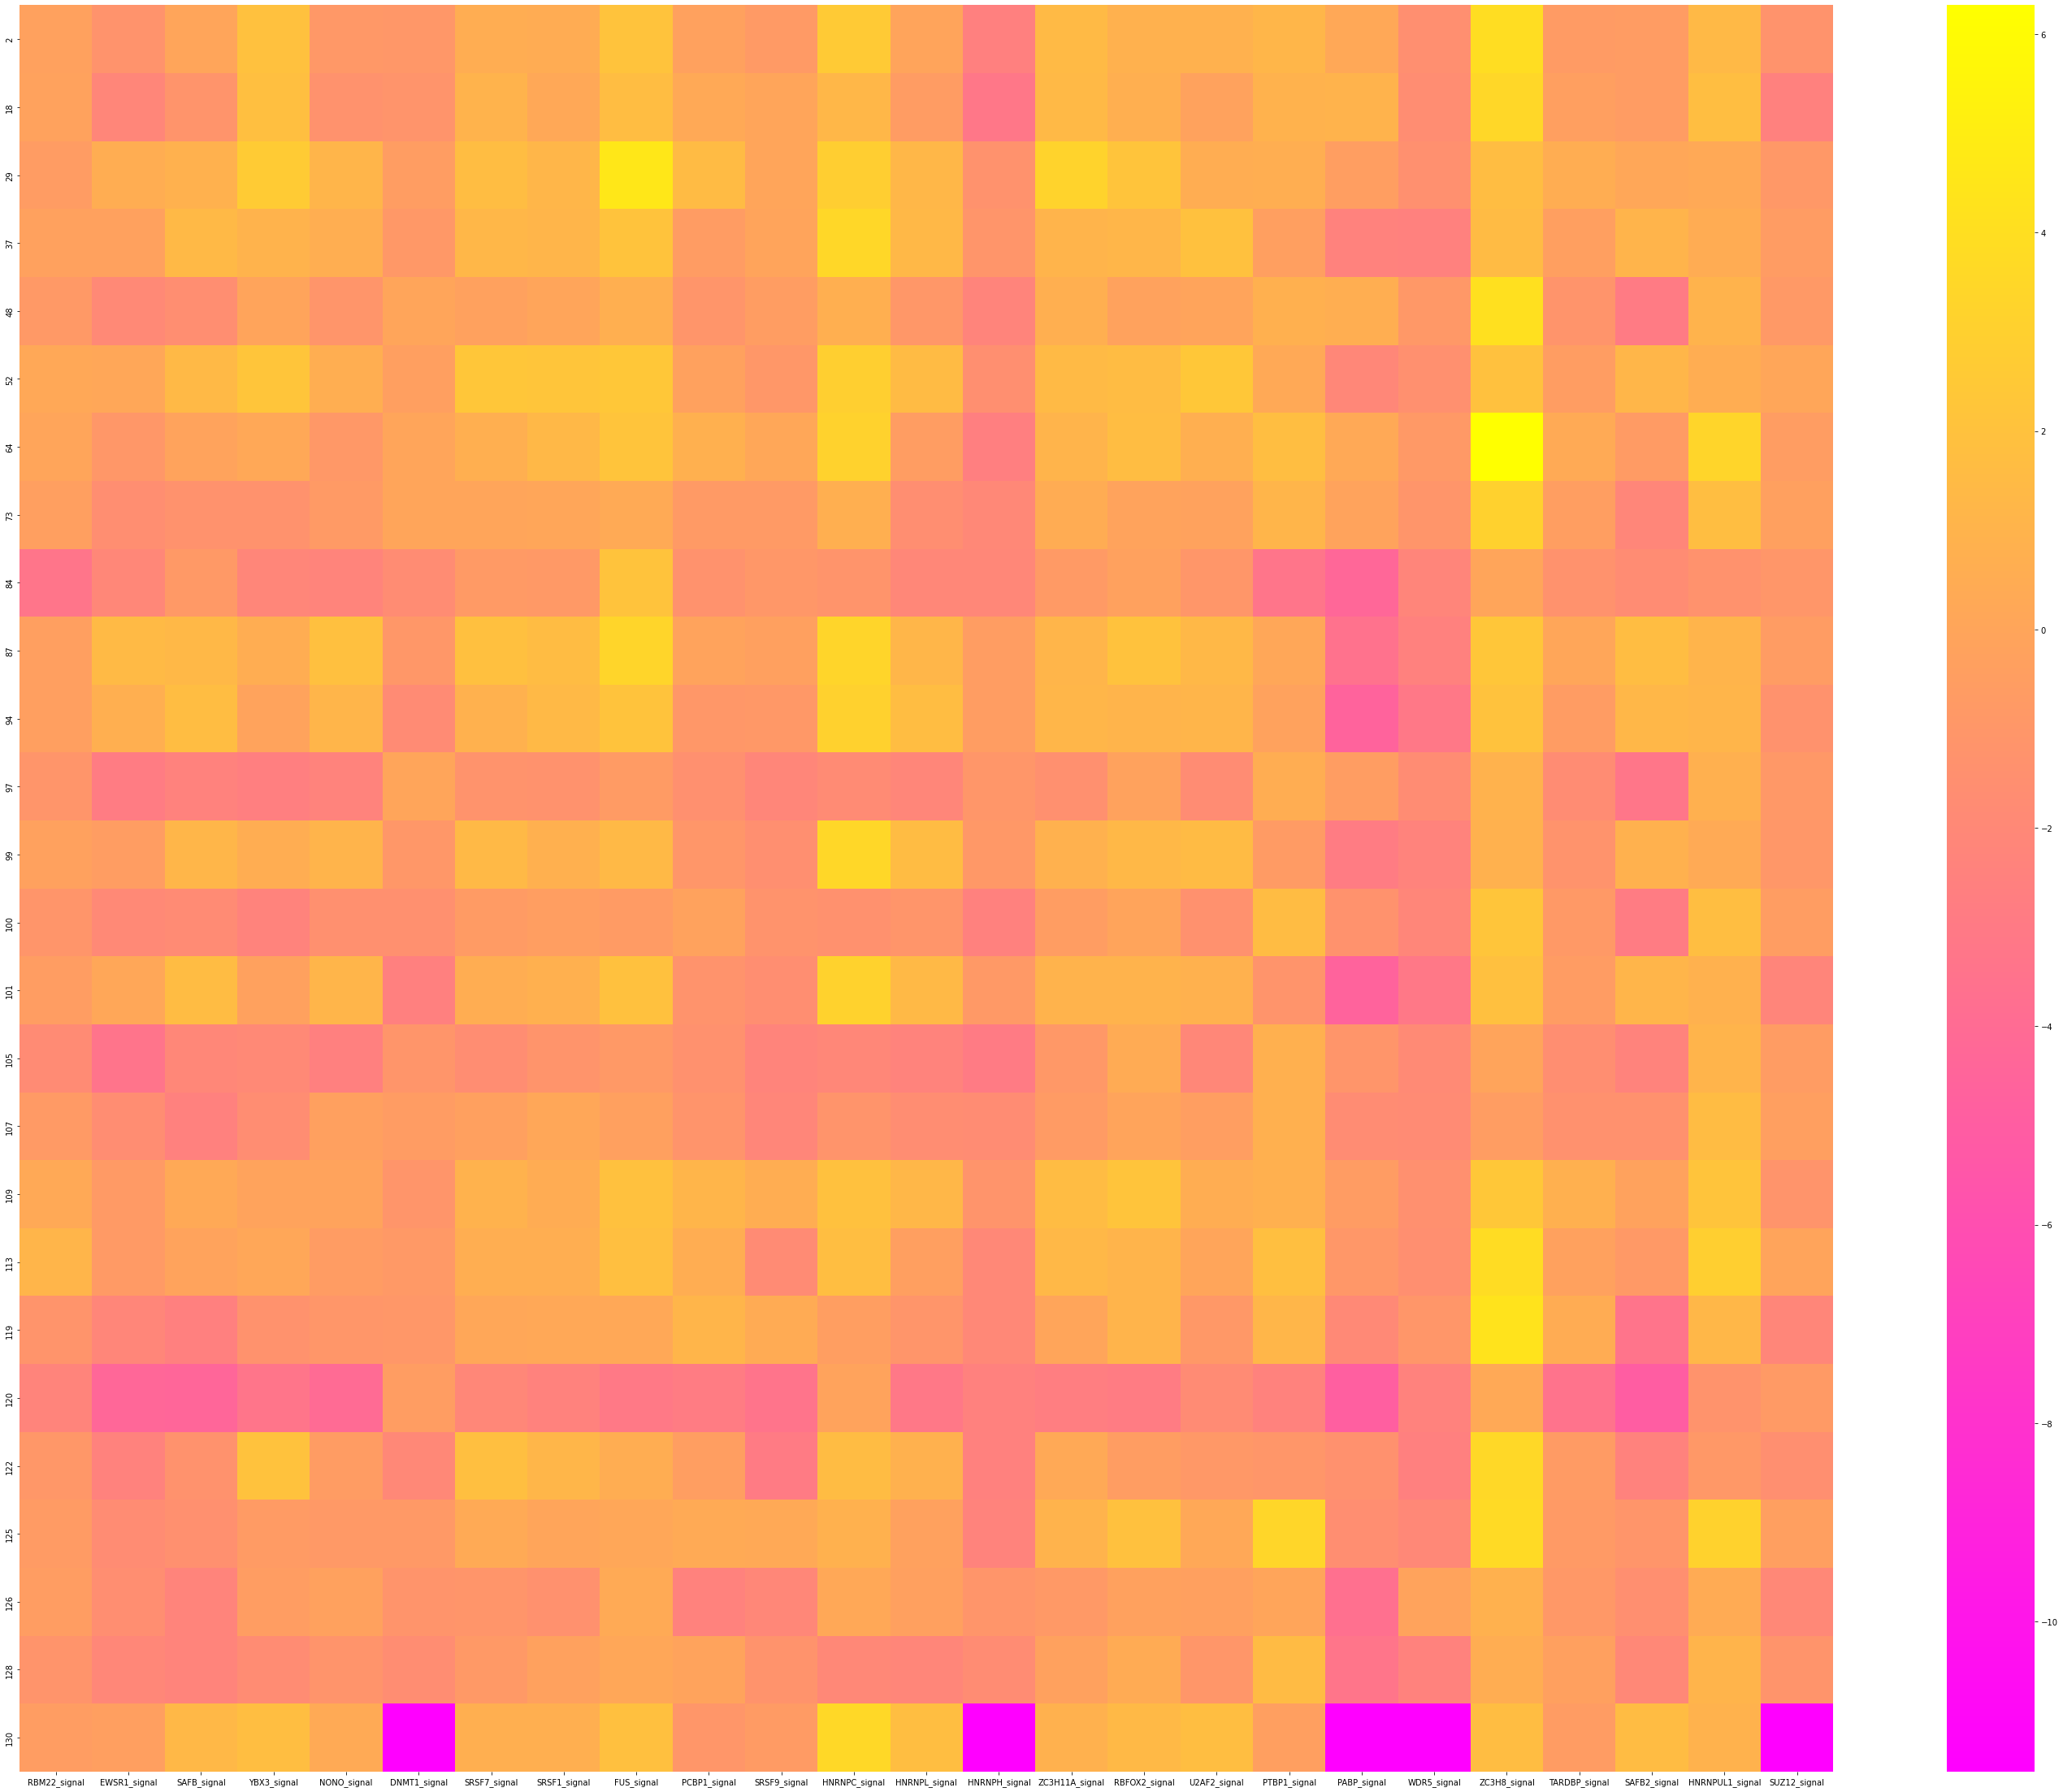

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(50,40))
ax = sns.heatmap(data=np.log(fc_tbl.iloc[:, 1:-2]), cmap="spring")

In [13]:
# prepare data for tables
cls = ["gene", "count"]
cldct = {i : cl for i, cl in enumerate(cls)}

chp_table = pd.read_csv(grid_chP, sep='\t').loc[:,["gene_name_un", "zscore"]]

# read protein list
protein_list = (pd.Series(glob.glob("eCLIP_mESC/*")).apply(lambda x: x.split('/')[1].split('.')[0])
                .drop_duplicates())

protein_list = protein_list[~protein_list.str.startswith("INPUT")]
res_dt_eCLIP = {p : 0 for p in protein_list}


l = []
for PROT in tqdm(protein_list):

    # load input counts
    fname = f"eCLIP_mESC/{PROT}.INPUT.txt"
    with open(fname, 'r') as fin:
        input_dct = eval(fin.readline())
        input_cnts = pd.DataFrame.from_dict(input_dct.items()).rename(columns = cldct)
        del input_dct
    
    # load protein counts
    fname = f"eCLIP_mESC/{PROT}.EXPERIMENT.txt"
    with open(fname, 'r') as fin:
        exp_d = eval(fin.readline())
        exp_cnts = pd.DataFrame.from_dict(exp_d.items()).rename(columns = cldct)
        del exp_d

    df = (exp_cnts.merge(input_cnts, how="outer", on="gene", suffixes=("_exp", "_inp"))
          .fillna(value=0)
          .set_index("gene")
         ) + 1
    df["FC"] = df.count_exp/df.count_inp
    cols = ["gene", "FC"]
    df = (df.reset_index()
          .merge(chp_table, left_on="gene", right_on="gene_name_un")
          .loc[:, cols]
          .rename(columns={"FC": f"{PROT}_signal_eCLIP"})
         )
    l.append(df)

  0%|          | 0/3 [00:00<?, ?it/s]

In [14]:
# prepare data for tables
cls = ["gene", "count"]
cldct = {i : cl for i, cl in enumerate(cls)}

chp_table = pd.read_csv(grid_chP, sep='\t').loc[:,["gene_name_un", "zscore"]]

# read protein list
protein_list = (pd.Series(glob.glob("fRIP_mESC/*")).apply(lambda x: x.split('/')[1].split('.')[0])
                .drop_duplicates())

protein_list = protein_list[~protein_list.str.startswith("INPUT")]
res_dt_eCLIP = {p : 0 for p in protein_list}



for PROT in tqdm(protein_list):

    # load input counts
    fname = f"fRIP_mESC/{PROT}.INPUT.txt"
    with open(fname, 'r') as fin:
        input_dct = eval(fin.readline())
        input_cnts = pd.DataFrame.from_dict(input_dct.items()).rename(columns = cldct)
        del input_dct
    
    # load protein counts
    fname = f"fRIP_mESC/{PROT}.EXPERIMENT.txt"
    with open(fname, 'r') as fin:
        exp_d = eval(fin.readline())
        exp_cnts = pd.DataFrame.from_dict(exp_d.items()).rename(columns = cldct)
        del exp_d

    df = (exp_cnts.merge(input_cnts, how="outer", on="gene", suffixes=("_exp", "_inp"))
          .fillna(value=0)
          .set_index("gene")
         ) + 1
    df["FC"] = df.count_exp/df.count_inp
    cols = ["gene", "FC"]
    df = (df.reset_index()
          .merge(chp_table, left_on="gene", right_on="gene_name_un")
          .loc[:, cols]
          .rename(columns={"FC": f"{PROT}_signal_fRIP"})
         )
    l.append(df)

  0%|          | 0/2 [00:00<?, ?it/s]

In [15]:
from functools import reduce

fc_tbl = reduce(lambda df1,df2: pd.merge(df1,df2,on='gene', how="outer").fillna(10e-6), l)

In [18]:
fc_tbl.to_csv("/home/daniil/Desktop/bioinformatics_group/FOLD_CHANGES_mESC.tab")

,gene,HNRNPK_signal_eCLIP,EZH2_signal_eCLIP,SUZ12_signal_eCLIP,WDR5_signal_fRIP,SUZ12_signal_fRIP,name,type,zscore
0,5031425E22Rik,4.768190,508.333333,13.764706,2.682884,0.090909,5031425E22Rik,lincRNA,1.358108
1,Gm49936,2.036178,5810.000000,0.949062,2.541337,0.126915,Gm49936,lincRNA,1.513742
2,Snhg14,2.118956,1663.000000,0.473856,3.102448,0.058099,Snhg14,processed_transcript,0.089161
3,4930519F16Rik,7.244318,191.000000,0.166667,2.720588,0.294118,4930519F16Rik,transcribed_unitary_pseudogene,1.620236
4,Gm22042,0.396779,172.814286,0.874838,1.636364,0.045455,Gm22042,snRNA,6.626562
...,...,...,...,...,...,...,...,...,...
117,Gm24540,0.000010,0.000010,0.000010,2.000000,0.000010,Gm24540,snRNA,5.929100
118,Snora69,0.000010,0.000010,0.000010,1.000000,0.000010,Snora69,snoRNA,5.745084
119,Gm24968,0.000010,0.000010,0.000010,2.000000,0.000010,Gm24968,snRNA,5.861089
120,Rnu6,0.000010,0.000010,0.000010,2.000000,0.000010,Rnu6,snRNA,5.861089


In [17]:
fc_tbl = fc_tbl.merge(triad_rna_mESC, left_on="gene", right_on="name")#.iloc[:, [*range(55),56, 57]]

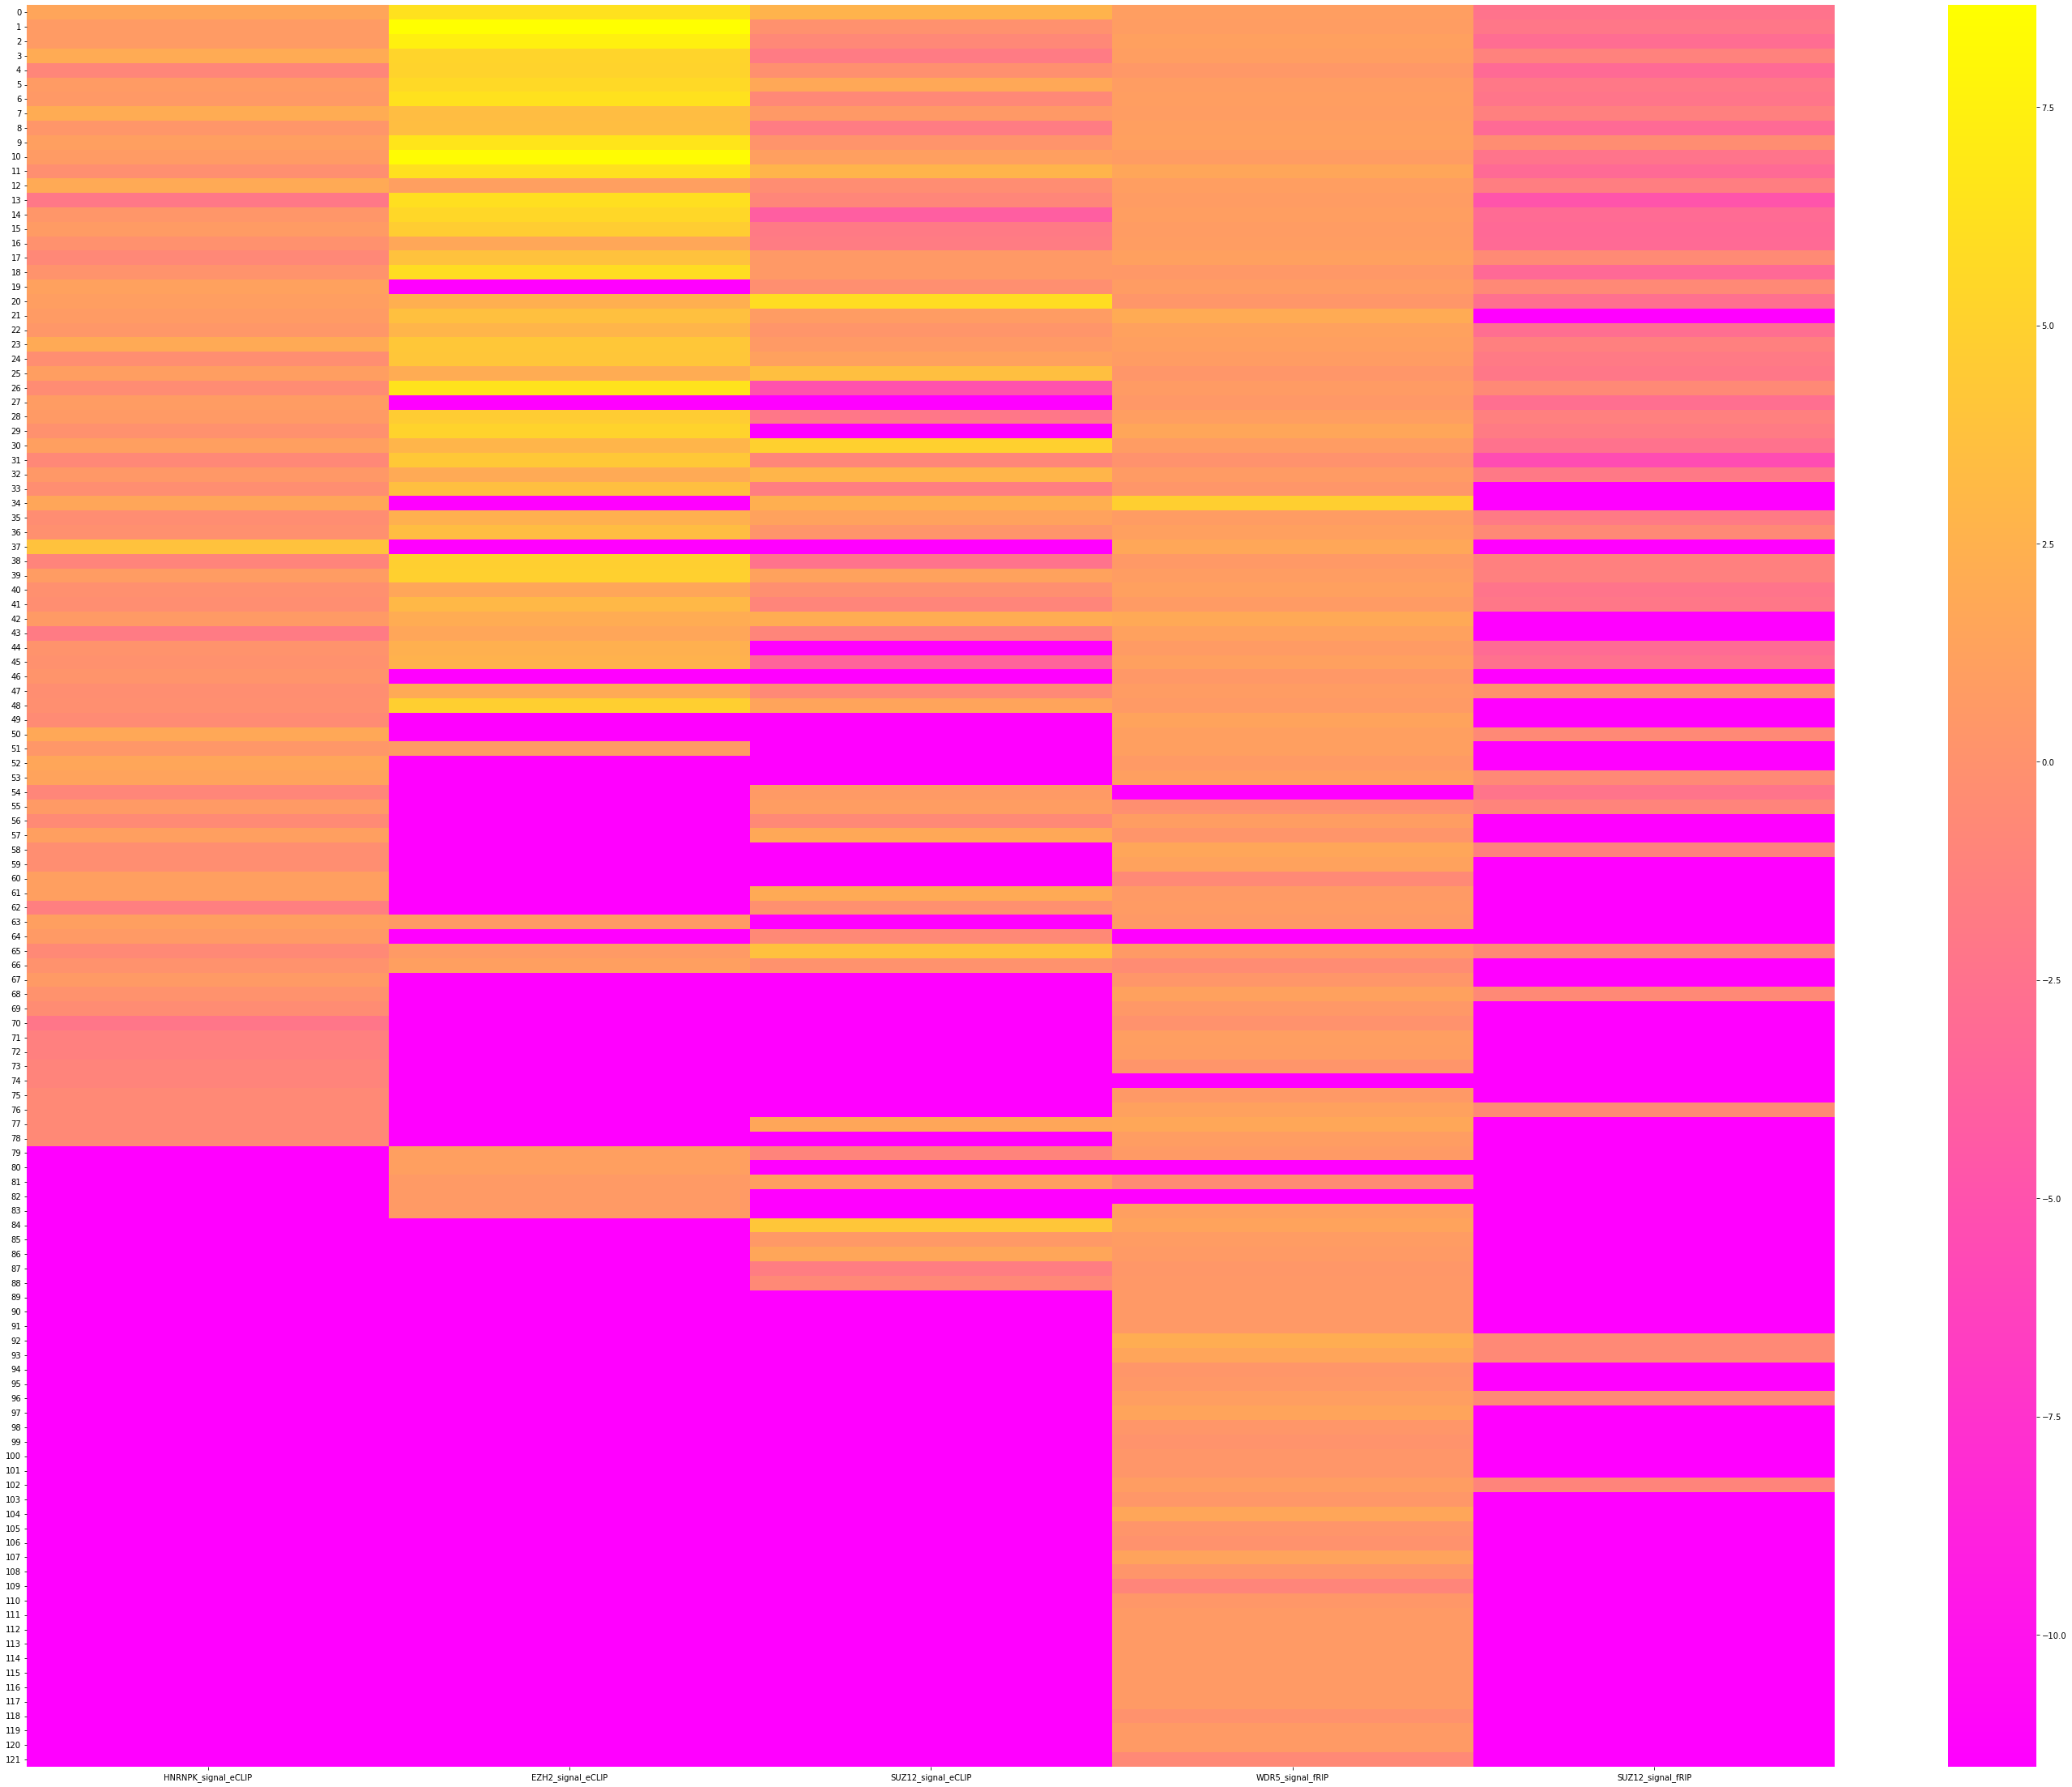

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(50,40))
ax = sns.heatmap(data=np.log(fc_tbl.iloc[:, 1:-3]), cmap="spring")
#ax.set_yticks(fc_tbl.gene.values)

In [24]:
fc_tbl.iloc[:, :-3].to_csv("~/Desktop/bioinformatics_group/FOLD_CHANGES_mESC.tsv", sep='\t', index=False)